# Deep Learning

This notebook is based on chapter 2 of the book Generative Deep Learning by D. Foster. In this notebook the [CIFAR-10 dataset](https://en.wikipedia.org/wiki/CIFAR-10),
a collection of 60.000 color images, is used to train and test two different neural networks architectures. The neural networs are implemented
using the [Keras](https://keras.io/) library. In this notebook discriminative rather than generative neural networs are build.
The building blocks of these neural networks are also used in generative models. Therefore it makes sense to explore them first. This
will aid the understanding of the more complex networks afterwards. 

## Libraries
Before strating to implement a neural network we first install and import the necessary libraries. 
These libraries can be installed using 
the following [pip](https://pip.pypa.io/en/stable/) command. 

```zsh
pip install numpy matplotlib tensorflow keras
```

After the installation the libraries are imported using the statements in the following cell.

## Parameters and helpers
The following cell defines the parameter `CLASSES`. These are the names of the 10 classes of images in the CIFAR-10 dataset.
In addition, the helper function `display` is defined. It can be used do select and display 10 random imaged for the dataset. 

In [31]:
import random

CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

def display(images, n=10):
    """
    Displays n random images from the supplied array.
    """
    if images.max() > 1.0:
        images = images / 255.0
    
    plt.figure()
    if len(images) > n:
        indices = random.sample(range(len(images)),k=n)
    else: 
        indices = range(len(images))
        
    for i, j in enumerate(indices):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[j])
        plt.axis("off")

plt.show()

# Multilayer Perceptron (MLP)
The first type of neureal network we create is the [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron). 
## 1. Prepare the data
In order to train the MLP we first need to load and prepare the dataset. The dataset can be loaded using the [Keras datasets module](https://keras.io/api/datasets/). 
The result of loading the dataset is 50.000 training images (`x_train`) and their corresponding categories (`y_train`) and 10.000 test images and their categories
(`x_test` and `y_test`respectively).

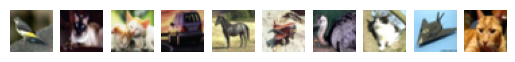

In [41]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
display(x_train)

Each input images has the shape 32 x* 32 * 3. The size of the images is 32 * 32 pixels. As these are 
color images their is one 32 * 32 array for each of the [RBG](https://en.wikipedia.org/wiki/RGB_color_model) colors. 

In orde to use the data to train a neural network two preprocessing steps are necessary:
1. converting the values from `int` in the range 0 - 255 into `float`s in the range 0 - 1
2. Convert the classification into a categorial representation.

In [42]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 2. Build the model
The next step is to build the MLP. The MLP consists of 5 layers:

1. The [input layer](https://keras.io/api/layers/core_layers/input/) of shape `(32, 32, 3)`
2. A [flatten layer](https://keras.io/api/layers/reshaping_layers/flatten/)
3. A [dense layer](https://keras.io/api/layers/core_layers/dense/) with 200 output neurons
4. A [dense layer](https://keras.io/api/layers/core_layers/dense/) with 150 output neurons
5. A output layer with 10 neurons representing the 10 categories of our dataset.

The following skets show the architecture of the MLP.

![MLP Architecture](imgs/mlp.png)

This architecture can be build using the following python code. Note that different [activation functions](https://keras.io/api/layers/activations/)
are used on the different layers. 

In [44]:
input_layer = layers.Input((32, 32, 3))

x = layers.Flatten()(input_layer)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dense(150, activation="relu")(x)

output_layer = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       614,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,260 (2.47 MB)

 Trainable params: 646,260 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

The model summary shows the nuber of parameters for each layer. For example, the first dense layer has 614.600 parameters.
However, 3072 * 200 is 314.400. The reason is that each neuron also has one additional bias input, that allways outputs 1. Therefore, the
number of parameters is 200 * (3072 + 1) = 614.600.

## 3. Train the model
The next step is trainig the model. For this a loss function is needed to calculate the difference between the output of the 
neural network and the expected output. Different [loss functions](https://keras.io/api/losses/) are available in Keras. 
When working with a classification problem the categorical cross-entropy is the correct loss function to use. 

The training of the model is done using the `fit` function. 

In [45]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2935 - loss: 1.9514
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3978 - loss: 1.6900
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4326 - loss: 1.5904
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4519 - loss: 1.5347
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4687 - loss: 1.4870
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4782 - loss: 1.4555
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4939 - loss: 1.4265
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5037 - loss: 1.3925
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5099 - loss: 1.3753
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5196 - loss: 1.3467


## 4. Evaluation & prediction 
Once the model is trained it can be evaluated using the `evaluate` function. The evaluate function returns the metrics that
are used by the model. In this case the categorical crossentropy and the accuracy.

In [50]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.5022 - loss: 1.4142


[1.4236422777175903, 0.49880000948905945]

Let's see the predictions for 10 random test images. 

In [51]:
preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


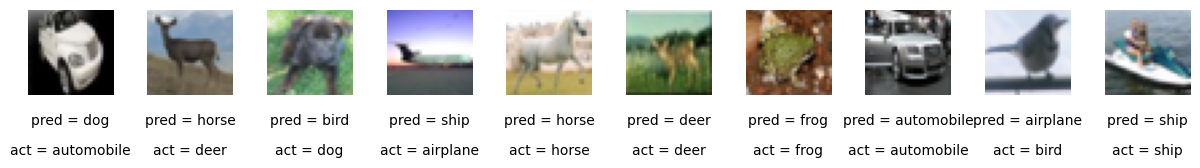

In [52]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )

    ax.imshow(img)

Of cause it is also possible to predict the class of any other image. Below some random image from a ship is used. 

In [77]:
from PIL import Image
image = np.array(Image.open("imgs/ship.jpg"))
images = np.array([image])
prediction = model.predict(images)
CLASSES[np.argmax(prediction, axis=-1)][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


'ship'

# Outlook
In this notebook we build a simple MLP and trained it. While the MLP is able to classify
some of the images correctly, a accuracy of ~ 50% is not very impressive. It is possible to improve the 
performance of the model  by choosing different architectures. For example, a 
[Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network)
would outperform the simply MLP created above. For details on convolutional neural network cf. chapter 
2 of the book *Generative Deep Learning*.

# References
- D. Foster, Generative Deep Learning, 2nd Edition. 2023. 